In [ ]:
import os
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from numpy import random
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/Shareddrives/capstone-project-c22-ps085/ML/dataset/trashnet_data"
os.listdir(base_path)

Mounted at /content/drive


['constants.py',
 'dataset-original.zip',
 'dataset-resized.zip',
 'README.txt',
 'resize.py',
 'data',
 'Copy of preprocess_data (1).ipynb',
 'Copy of preprocess_data.ipynb',
 'preprocess_data.ipynb',
 'saved_model',
 'modelh5',
 'preprocess_data_kncx.ipynb']

## unzipping data set

In [ ]:
# try:
#   dir = 'data'
#   path = os.path.join(base_path, dir)
#   os.mkdir(path)
#   print("Directory created")
# except FileExistsError:
#   print("Directory existed")

# data_zip = 'dataset-resized.zip'
# dir = os.path.join(base_path, 'data')
# with zipfile.ZipFile(os.path.join(base_path, data_zip), 'r') as zip_ref:
#     zip_ref.extractall(dir)

In [ ]:
dataset_path = os.path.join(base_path, 'data', 'dataset-resized')
print(os.listdir(dataset_path))

# remove .hidden 
try:
  os.remove(os.path.join(dataset_path, '.DS_Store'))
  print('File .DS_Store deleted')
except FileNotFoundError:
  pass

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## Check image detail

In [ ]:
# Size image
class_image = os.listdir(dataset_path)
class_image

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

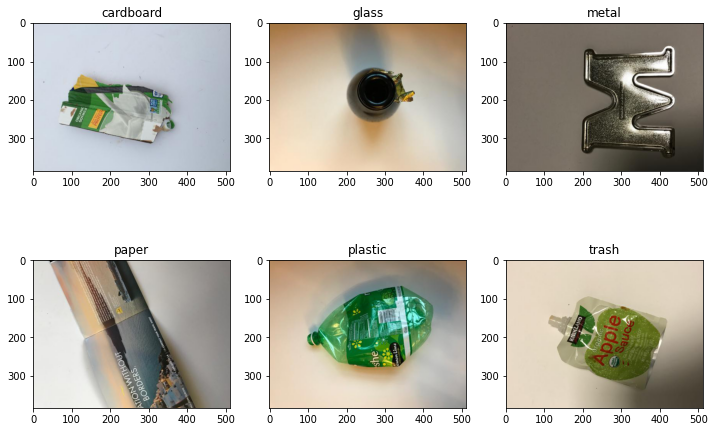

In [ ]:
def get_random_data_perclass():
  random_data_perclass = []

  for root, _, files in os.walk(dataset_path):
    # skip check folder in data_resized
    if len(files) == 0: continue
    random_index = random.randint(0, len(files) - 1)
    rand_data_path = os.path.join(root,  files[random_index])
    random_data_perclass.append(rand_data_path)
  return random_data_perclass

# subplot dimension
nrows = 2
ncols = 3

# Index for iterating over images
pic_index = 0
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

for i, img_path in enumerate(get_random_data_perclass()):
# Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('On')
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.title(class_image[i])


In [ ]:
# get all data path, per class

def get_all_image_path():
  data = []
  for root, dirs, files in os.walk(dataset_path):
    # skip check folder in data_resized
    if len(files) == 0: continue
    for file in files:
      img_path = os.path.join(root, file)
      data.append(img_path)
  
  return data
  
len(get_all_image_path())

2527

In [ ]:
# from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation

batch_size = 120
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  shuffle=True,
  validation_split=0.2,
  subset="training",
  seed=123,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  shuffle=True,
  validation_split=0.2,
  subset="validation",
  seed=123,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


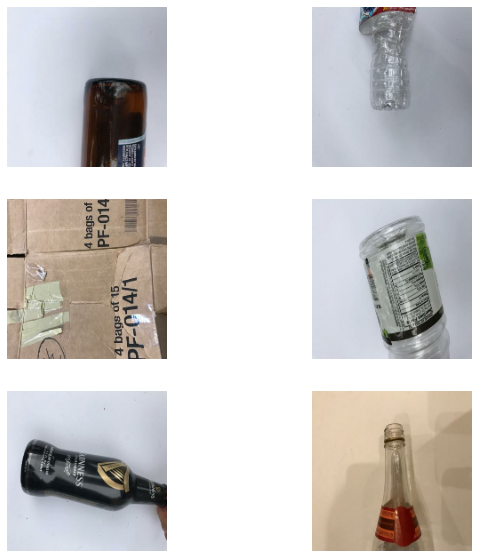

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    # plt.title(class_names[labels[i]])
    plt.axis("off")

## Image Augmentaion and Modeling

In [ ]:
# augmentastion
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential(
  [
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
    tf.keras.layers.Rescaling(1./255.)
  ]
)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation((-0.3,0.3)),
  tf.keras.layers.RandomZoom((-0.2,0.1)),
  tf.keras.layers.RandomTranslation(0.1,0.1)
])



In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(180, 180, 3)),

    resize_and_rescale,         
    data_augmentation,

    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, None)    0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, None)    0         
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                  

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=(0.001)),
              metrics=['accuracy'])

## Training

In [ ]:
ACCURACY_THRESHOLD = 0.95
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

In [ ]:
callbacks = myCallback()
history = model.fit(
                    train_ds,
                    validation_data=val_ds,
                    epochs=200,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/200
17/17 [==============================] - 217s 13s/step - loss: 1.7411 - accuracy: 0.2082 - val_loss: 1.7029 - val_accuracy: 0.2455
Epoch 2/200
17/17 [==============================] - 7s 267ms/step - loss: 1.6810 - accuracy: 0.2265 - val_loss: 1.6568 - val_accuracy: 0.2277
Epoch 3/200
17/17 [==============================] - 7s 270ms/step - loss: 1.6033 - accuracy: 0.2671 - val_loss: 1.5647 - val_accuracy: 0.2713
Epoch 4/200
17/17 [==============================] - 7s 268ms/step - loss: 1.5014 - accuracy: 0.3670 - val_loss: 1.4700 - val_accuracy: 0.4218
Epoch 5/200
17/17 [==============================] - 7s 271ms/step - loss: 1.4554 - accuracy: 0.4001 - val_loss: 1.5022 - val_accuracy: 0.3426
Epoch 6/200
17/17 [==============================] - 7s 267ms/step - loss: 1.4306 - accuracy: 0.4219 - val_loss: 1.3656 - val_accuracy: 0.4574
Epoch 7/200
17/17 [==============================] - 7s 265ms/step - loss: 1.3820 - accuracy: 0.4308 - val_loss: 1.3454 - val_accuracy: 0.4436

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


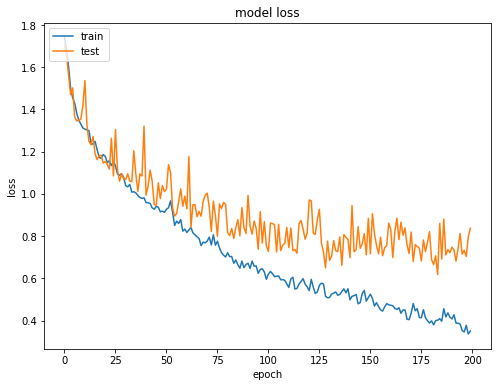

In [ ]:
print(history.history.keys())

# import matplotlib.pylab as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import datetime
now = datetime.datetime.now()
time = now.strftime("%Y-%m-%d_%H:%M:%S")

In [ ]:
!mkdir -p $base_path/saved_model/$time
path = os.path.join(base_path, 'saved_model', time)
pathh5 = os.path.join(base_path, 'modelh5')

In [ ]:
model.save( os.path.join(pathh5, f'trashnet_{time}-self-learn-200EP-augmented in model layer.h5'))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


Saving sampah-plastik-jangan-dibuang4.png to sampah-plastik-jangan-dibuang4 (3).png
[9.8696208e-01 1.0880203e-03 2.6750267e-05 3.6767573e-04 1.1536400e-02
 1.9090843e-05]
cardboard with a 98.70 percent confidence.


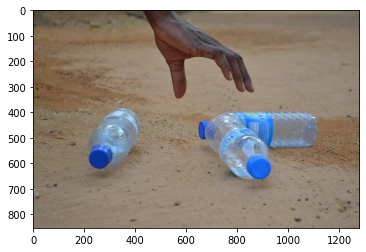

In [ ]:
class_names = train_ds.class_names
print(class_names)
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
    img_path = os.path.join('/content', fn)

    img = tf.keras.utils.load_img(
        img_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    
    img = mpimg.imread(img_path)
    plt.imshow(img)
    

    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    print(predictions[0])
    # score = tf.nn.softmax(predictions[0])

print(f"{class_names[np.argmax(predictions[0])]} with a {100 * np.max(predictions[0]):.2f} percent confidence.")